**SOFT DEADLINE:** `20.03.2022 23:59 msk` 

# [5 points] Part 1. Data cleaning

The task is to clear the text data of the crawled web-pages from different sites. 

It is necessary to ensure that the distribution of the 100 most frequent words includes only meaningful words in english language (not particles, conjunctions, prepositions, numbers, tags, symbols).

Determine the order of operations below and carry out the appropriate cleaning.

1. Remove non-english words
1. Remove html-tags (try to do it with regular expression, or play with beautifulsoap library)
1. Apply lemmatization / stemming
1. Remove stop-words
1. Additional processing - At your own initiative, if this helps to obtain a better distribution

#### Hints

1. To do text processing you may use nltk and re libraries
1. and / or any other libraries on your choise

In [ ]:
#import libraries

!pip install lxml
!pip install boilerpy3
!pip install datasketch
!pip install topicnet

from datasketch import MinHash, MinHashLSH
import lxml.html.clean
import re
from boilerpy3 import extractors
import re
import csv
import string
import nltk
from nltk.corpus import stopwords
import spacy
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from progressbar import ProgressBar
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim.downloader
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from topicnet.cooking_machine.model_constructor import init_simple_default_model
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.experiment import Experiment
from topicnet.viewers import TopTokensViewer
from topicnet.cooking_machine import dataset
from collections import Counter
import artm
from itertools import combinations
from topicnet.cooking_machine.models.base_score import BaseScore
from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder,
)
from gensim.models import ldamodel

glove_vectors = gensim.downloader.load('glove-twitter-25')
nltk.download('stopwords')
nltk.download('wordnet')

#### Data reading

The dataset for this part can be downloaded here: `https://drive.google.com/file/d/1wLwo83J-ikCCZY2RAoYx8NghaSaQ-lBA/view?usp=sharing`

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

websites = pd.read_csv('/content/drive/My Drive/zweb_sites_data.csv', header=0, sep=',')

Mounted at /content/drive/


#### Data processing

In [ ]:
def beautifulsoup_extract_text(raw_html):
    
    # Creating the beautifulsoup object:
    soup = BeautifulSoup(raw_html, 'lxml')
    # Finding the text:
    text = soup.find_all(text=True)
    # Remove unwanted tag elements:
    cleaned_text = ''
    blacklist = [
        '[document]', 'noscript', 'header', 'html',
        'meta', 'head', 'input', 'script', 'style',
        'link', 'a']

    for item in text:
        #if item.parent.name not in blacklist:
        if item.parent.name == 'p':
            cleaned_text += '{} '.format(item)
            
    # Remove any tab separation and strip the text:
    cleaned_text = cleaned_text.replace('\t', ' ')
    cleaned_text = cleaned_text.replace('\n', ' ')
    cleaned_text = cleaned_text.replace('\r', ' ')
    
    return cleaned_text.strip()

In [ ]:
# subsampling from initial data
N = 5000
websites_sample = websites.sample(n=N, random_state=0)
websites_sample

,text
20749,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T..."
27009,<HTML><HEAD><TITLE>Quote for EK - FreeRealTime...
8834,"\n \n \n \n \n<!DOCTYPE HTML PUBLIC ""-//W3C//..."
66783,\n<html><head>\n<html>\n<head>\n\n<title>Weeke...
31151,"<!-- START 'htmlHead' -->\n<link rel=""alternat..."
...,...
25678,<!-- Generated on SEC-MW08 -->\n<SCRIPT LANGUA...
3664,"\n\n\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML..."
5687,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.1//..."
53377,\n\n\n\n\n\n\n\n\n\n\n\t\n\n\n\t\n\t\t\n\t\n\t...


In [ ]:
# cleaning text of html

pbar = ProgressBar()
for i in pbar(websites_sample['text'].index):
    websites_sample["text"].loc[ i ] = beautifulsoup_extract_text(websites_sample["text"].loc[ i ])
    

100% (5000 of 5000) |####################| Elapsed Time: 0:05:46 Time:  0:05:46


In [ ]:
for i in websites_sample.index:
    if websites_sample["text"].loc[i] == '':
        websites_sample = websites_sample.drop( i )


In [ ]:
signs = string.punctuation
for i in range(10):
    signs += str(i)

sp = spacy.load('en_core_web_sm')

stop_words = set(stopwords.words('english'))

stop_words.add('-PRON-')
stop_words.add('average')
stop_words.add('inc')
stop_words.add('time')
stop_words.add('new')
stop_words.add('right')
stop_words.add('provide')
stop_words.add('user')
stop_words.add('use')
stop_words.add('minute')
stop_words.add('day')
stop_words.add('get')
stop_words.add('th')
stop_words.add('data')
stop_words.add('one')
stop_words.add('see')
stop_words.add('year')
stop_words.add('make')
stop_words.add('copyright')
stop_words.add('site')
stop_words.add('give')
stop_words.add('find')
stop_words.add('like')
stop_words.add('th')


pbar = ProgressBar()

for i in pbar(websites_sample['text'].index):

    text = websites_sample["text"].loc[ i ]

    # split into words by white space
    words = text.split()

    # normalizing case
    words = [word.lower() for word in words]

    # removing punctuation and digits
    table = str.maketrans('', '', signs)
    words = [w.translate(table) for w in words]
    words = [word for word in words if len(word) > 1]

    # lemmatization
    temp_text = ''
    for w in words:
        temp_text += str(w) + str(' ')
    words = [token.lemma_ for token in sp(temp_text)]
    
    # removing stop words
    words = [w for w in words if not w in stop_words]

    if len(words) < 10:
        websites_sample = websites_sample.drop( i )
    else:
        temp_text = ''
        for w in words:
            temp_text += str(w) + str(' ')
        websites_sample["text"].loc[ i ] = temp_text

100% (2367 of 2367) |####################| Elapsed Time: 0:02:05 Time:  0:02:05


#### Vizualization

As a visualisation, it is necessary to construct a frequency distribution of words (the 100 most common words), sorted by frequency. 

For visualization purposes we advice you to use plotly, but you are free to choose other libraries

In [ ]:
# estimating words appearance frequency
frequency = {}
pbar = ProgressBar()
for i in pbar(websites_sample['text'].index):
    
    text = websites_sample["text"].loc[ i ]
    words = text.split()

    for word in words:
        if word in frequency:
            frequency[word] += 1
        else:
            frequency[word] = 1

# Top 100 most used words
frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse = True))
print(list(frequency.items())[:50])

100% (1822 of 1822) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


[('game', 2210), ('stock', 1447), ('score', 1390), ('marketwatch', 889), ('player', 832), ('market', 817), ('play', 772), ('information', 758), ('critic', 718), ('datum', 656), ('delay', 637), ('take', 552), ('world', 531), ('reserve', 517), ('rating', 512), ('alert', 504), ('current', 490), ('news', 464), ('good', 463), ('quote', 454), ('businesswire', 428), ('analysis', 426), ('base', 425), ('company', 417), ('character', 397), ('goal', 389), ('jun', 387), ('way', 381), ('feature', 380), ('newswire', 377), ('nintendo', 374), ('pr', 373), ('also', 351), ('trading', 350), ('mode', 349), ('nasdaq', 343), ('trimable', 343), ('may', 338), ('service', 332), ('action', 330), ('story', 329), ('first', 326), ('sign', 324), ('back', 323), ('video', 322), ('wsjcom', 320), ('free', 317), ('interactive', 315), ('gameplay', 314), ('st', 312)]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


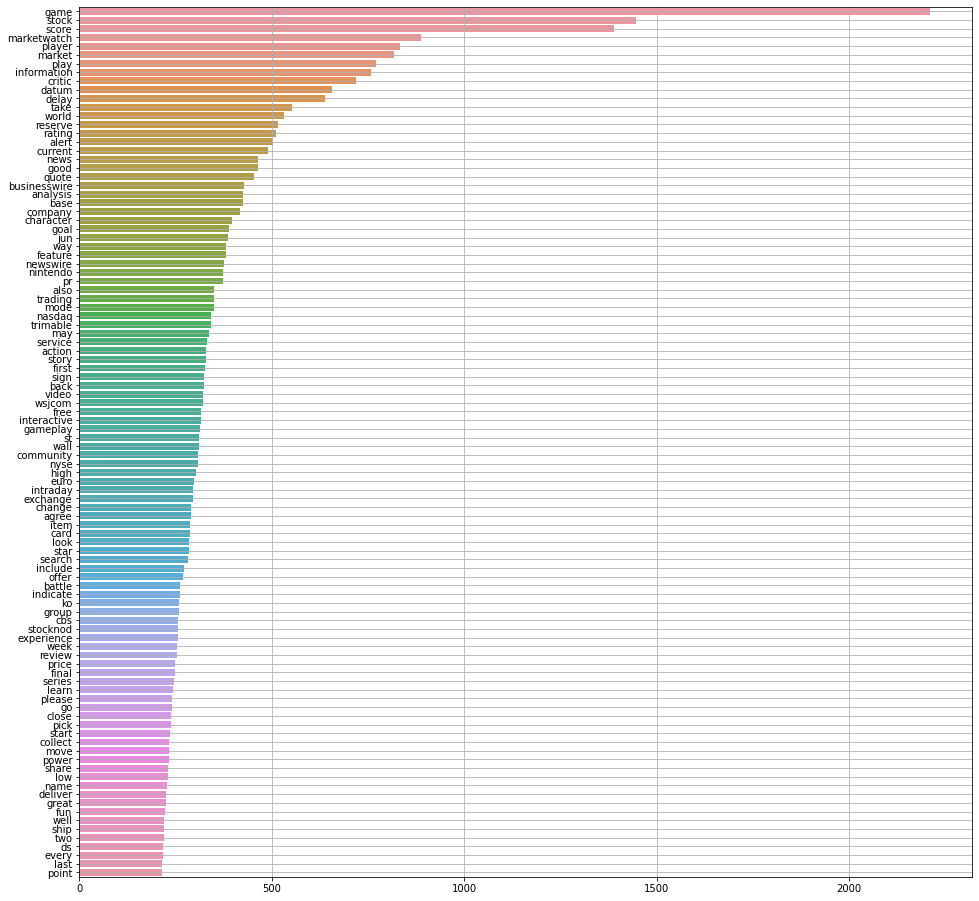

In [ ]:
val = list(frequency.values())
words_100 = list(frequency.keys())

plt.figure(figsize=(16, 16))
sns.barplot(val[0:100], words_100[0:100])
plt.grid(True)
plt.show()

#### Provide examples of processed text (some parts)

Is everything all right with the result of cleaning these examples? What kind of information was lost?

After processing most part of data seems okay, but there are some documents, which contain only few words and there are some documents, where some letters were lost

In [ ]:
print(websites_sample["text"].loc[20749])

create revere japanese developer treasure bangaio spirit reimagination hit dreamcast game bangaio twitchf shooter gameplay include level punish supermove exclusive content western version sensory overload firework onscreen bangaio spirit boast powerful level editor tool local wireless multiplayer four player pioneer sound load technology bangaio spirit blast retail store august exclusively nintendo ds critic score score 


In [ ]:
print(websites_sample["text"].loc[22709])

first gamer direct bens decision action work save world engage experience neverbeforeseen location enemy character totally unique adventure defend favorite location good ben tv show episode familiar foe critic score score news flash tenyearold save planet ben protector earth ben protector earth two ben well 


# [10 points] Part 2. Duplicates detection. LSH

#### Libraries you can use

1. LSH - https://github.com/ekzhu/datasketch
1. LSH - https://github.com/mattilyra/LSH
1. Any other library on your choise

1. Detect duplicated text (duplicates do not imply a complete word-to-word match, but texts that may contain a paraphrase, rearrangement of words, sentences)
1. Make a plot dependency of duplicates on shingle size (with fixed minhash length) 
1. Make a plot dependency of duplicates on minhash length (with fixed shingle size)

In [ ]:
# function for creating set of shingles 
def make_shingles(text, k):
    shingles = set()
    if k > len(text):
        shingles.add(text)
    else:
        for i in range(len(text))[:-k]:
            shingles.add(text[i:i+k])
    return list(shingles)

def LSH(data, k_shingle = 5, num_perm = 128, threshold = 0.5):
    
    array1 = []
    #Form Minhash
    for i in range(len(data)):
        m = MinHash(num_perm = num_perm)
        shingles = make_shingles(data[i], k_shingle)
        for d in shingles:
            m.update(d.encode('utf8'))
        array1.append(m)

    lsh = MinHashLSH(threshold = threshold, num_perm = num_perm)
    for i in range(len(array1)):
        lsh.insert(i, array1[i])

    duplicates_set = set()
    for val in array1:
        bucket = lsh.query(val)
        
        if len(bucket)>1:
            first_val = bucket[0]
            if first_val not in duplicates_set:
                duplicates_set.add(first_val)
    return list(duplicates_set)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


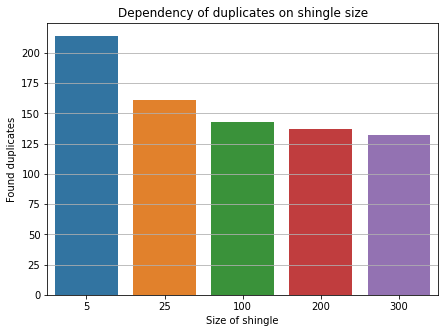

In [ ]:
# plot dependency of duplicates on shingle size (with fixed minhash length)

data_list = websites_sample["text"].tolist()

shingle_size = [5, 25, 100, 200, 300]
duplicates_num = []

for k in shingle_size:
    duplicates_num.append(len(LSH(data_list, k_shingle = k, num_perm = 10, threshold=0.5)))

plt.figure(figsize=(7, 5))
plt.grid(True)
plt.title('Dependency of duplicates on shingle size')
plt.xlabel('Size of shingle')
plt.ylabel('Found duplicates')
sns.barplot(shingle_size, duplicates_num)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


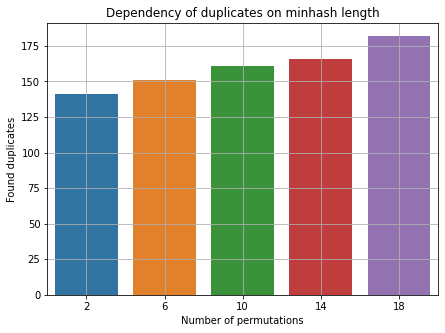

In [ ]:
#duplicates = LSH(data_list, k_shingle = 100, num_perm = 5, threshold=0.8)

permutations_num = [2, 6, 10, 14, 18]
duplicates_num = []

for num in permutations_num:
    duplicates_num.append(len(LSH(data_list, k_shingle = 25, num_perm = num, threshold=0.5)))

plt.figure(figsize=(7, 5))
sns.barplot(permutations_num, duplicates_num)
plt.grid(True)
plt.title('Dependency of duplicates on minhash length')
plt.xlabel('Number of permutations')
plt.ylabel('Found duplicates')
plt.show()

# [Optional 10 points] Part 3. Topic model

In this part you will learn how to do topic modeling with common tools and assess the resulting quality of the models. 

In [ ]:
stories = pd.read_csv('/content/drive/My Drive/data.csv')
stories

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


The provided data contain chunked stories by Edgar Allan Poe (EAP), Mary Shelley (MWS), and HP Lovecraft (HPL).

The dataset can be downloaded here: `https://drive.google.com/file/d/14tAjAzHr6UmFVFV7ABTyNHBh-dWHAaLH/view?usp=sharing`

#### Preprocess dataset with the functions from the Part 1

In [ ]:
signs = string.punctuation
for i in range(10):
    signs += str(i)

sp = spacy.load('en_core_web_sm')

stop_words = set(stopwords.words('english'))
stop_words.add('-PRON-')

stop_words.add('say')
stop_words.add('know')
stop_words.add('man')
stop_words.add('come')
stop_words.add('thing')
stop_words.add('make')
stop_words.add('time')
stop_words.add('day')
stop_words.add('great')


pbar = ProgressBar()

for i in pbar(stories['text'].index):

    text = stories["text"].loc[ i ]

    # split into words by white space
    words = text.split()

    # normalizing case
    words = [word.lower() for word in words]

    # removing punctuation and digits
    table = str.maketrans('', '', signs)
    words = [w.translate(table) for w in words]
    words = [word for word in words if len(word) > 1]

    # lemmatization
    temp_text = ''
    for w in words:
        temp_text += str(w) + str(' ')
    words = [token.lemma_ for token in sp(temp_text)]
    
    # removing stop words
    words = [w for w in words if not w in stop_words]

    temp_text = ''
    for w in words:
        temp_text += str(w) + str(' ')
    stories["text"].loc[ i ] = temp_text

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

100% (19579 of 19579) |##################| Elapsed Time: 0:04:55 Time:  0:04:55


#### Quality estimation

Implement the following three quality fuctions: `coherence` (or `tf-idf coherence`), `normalized PMI`, `based on the distributed word representation`(you can use pretrained w2v vectors or some other model). You are free to use any libraries (for instance gensim) and components.

In [ ]:
def coherence(corpus, topics):
    cm = CoherenceModel(topics=topics, 
                    texts=corpus,
                    coherence='c_v',  
                    dictionary=Dictionary(corpus),
                    topn=3)
    print(cm.get_coherence())
    return cm.get_coherence_per_topic()


def n_pmi(corpus, topics):
    cm = CoherenceModel(topics=topics, 
                    texts=corpus,
                    coherence='c_npmi',  
                    dictionary=Dictionary(corpus),
                    topn=3)
    print(cm.get_coherence())
    return cm.get_coherence_per_topic()


def bdwr(topics):
    glove_vectors = gensim.downloader.load('glove-twitter-25')
    k = 0
    sum_dist = 0
    topic_metr = []
    for topic in topics:
        for pair in combinations(topic, 2):
            word_1, word_2 = pair
            if word_1 in glove_vectors.wv.vocab and word_2 in glove_vectors.wv.vocab:
                dist = glove_vectors.distance(word_1, word_2)
                sum_dist += dist
                k += 1
        topic_metr.append(sum_dist/k)
        sum_dist = 0
        k = 0
    return topic_metr

### Topic modeling

Plot the histogram of resulting tokens counts in the processed datasets.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



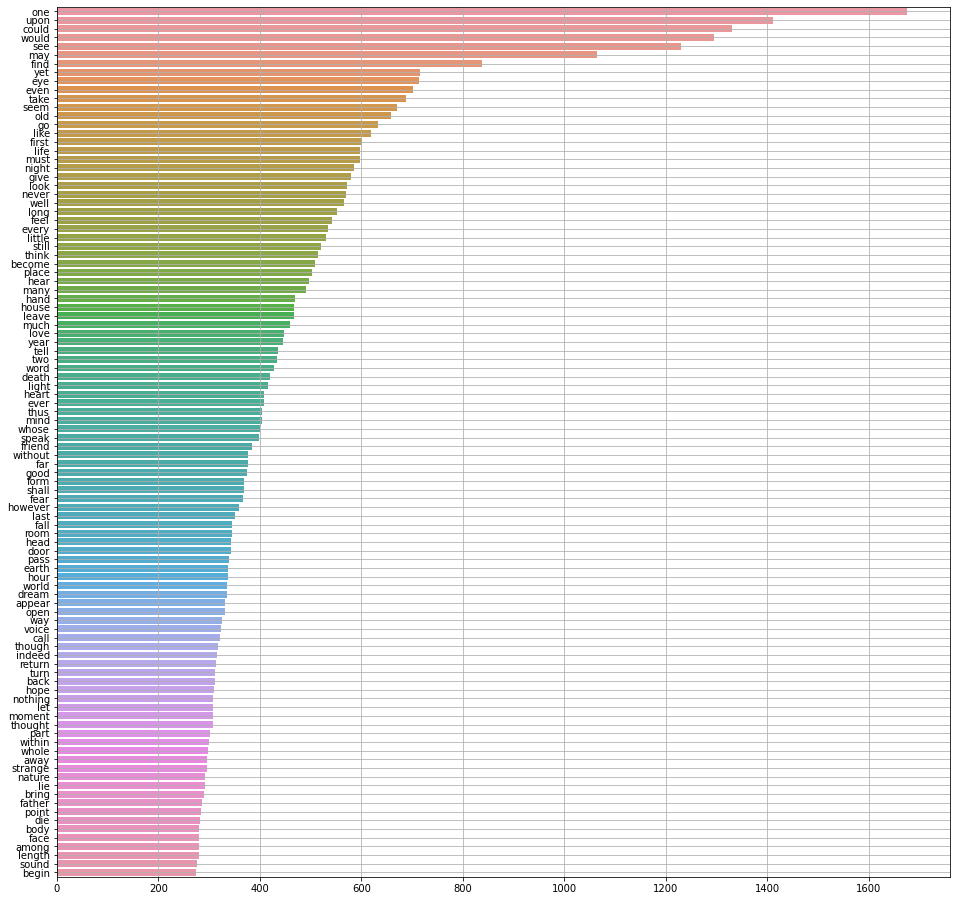

In [ ]:
# estimating words appearance frequency
frequency = {}
for i in stories['text'].index:
    text = stories["text"].loc[ i ]
    words = text.split()
    for word in words:
        if word in frequency:
            frequency[word] += 1
        else:
            frequency[word] = 1

# Top 100 most used words
frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse = True))
val = list(frequency.values())
words_100 = list(frequency.keys())
plt.figure(figsize=(16, 16))
sns.barplot(val[0:100], words_100[0:100])
plt.grid(True)
plt.show()

#### NMF

Implement topic modeling with NMF (you can use `sklearn.decomposition.NMF`) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 7), sharex=True)
    axes = axes.flatten()
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_cur = []
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        for word in top_features:
            topic_cur.append(word)
        topics.append(topic_cur)

        ax = axes[topic_idx]
        ax.barh(top_features, weights)
        ax.set_title(f"Topic {topic_idx +1}")
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major")
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title)

    plt.show()
    return(topics)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning:

`alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

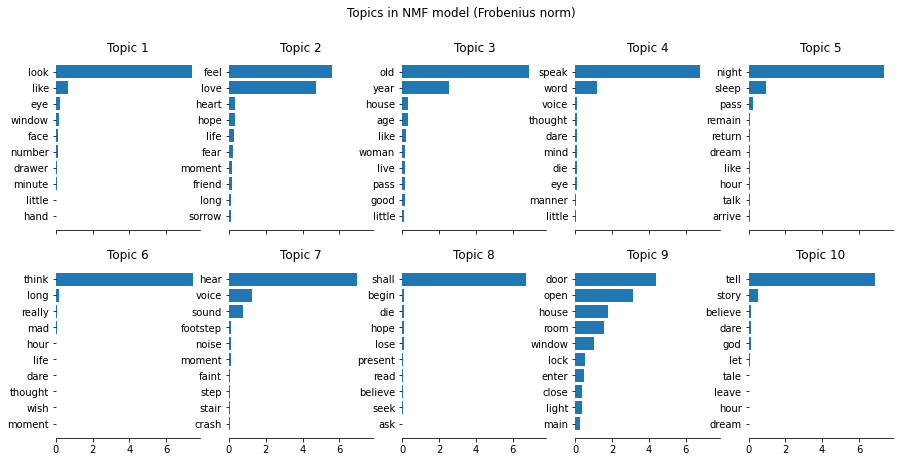

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=1, max_features=None, stop_words="english")

tfidf = tfidf_vectorizer.fit_transform(stories['text'])
nmf = NMF(n_components=10, random_state=10, alpha=0.1, l1_ratio=0.9).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10
topics_NMF = plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)"
)

#### LDA

Implement topic modeling with LDA (you can use gensim implementation) and print out resulting topics. Try to change hyperparameters to better fit the dataset.

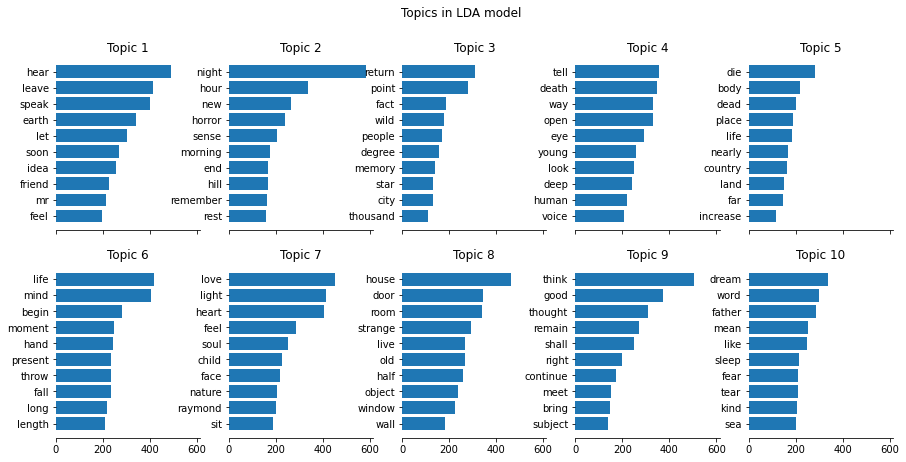

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=1, max_features=None, stop_words="english")
tf = tf_vectorizer.fit_transform(stories['text'])
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=15,
    learning_method="online",
    learning_offset=15.0,
    random_state=20,
)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()
topics_LDA = plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### Additive regularization of topic models 

Implement topic modeling with ARTM. You may use bigartm library (simple installation for linux: pip install bigartm) or TopicNet framework (`https://github.com/machine-intelligence-laboratory/TopicNet`)

Create artm topic model fit it to the data. Try to change hyperparameters (number of specific and background topics) to better fit the dataset. Play with smoothing and sparsing coefficients (use grid), try to add decorrelator. Print out resulting topics.

In [ ]:
# Vowpal Wabbit
def vowpalize_sequence(sequence):
    frequency = {}
    for word in sequence:
        if word in frequency:
            frequency[word] += 1
        else:
            frequency[word] = 1

    vals = list(frequency.values())
    words = list(frequency.keys())
    vw_string = ''
    for i in range(len(vals)):
        vw_string += words[i] + ":" + str(vals[i]) + ' '
    return vw_string

In [ ]:
bigram_measures = BigramAssocMeasures()

documents_split = []
for doc in stories['text']:
    documents_split.append(doc.split())

finder = BigramCollocationFinder.from_documents(documents_split)

finder.apply_freq_filter(5)
set_dict = set(finder.nbest(bigram_measures.pmi,32100)[100:])
documents = stories['text']
bigrams = []

for doc in documents:
    words = doc.split()
    entry = []
    for word_first, word_second in zip(words[:-1],words[1:]):
        entry.append('_'.join([word_first, word_second]))
    bigrams.append(entry)
    

stories['bigram'] = bigrams

vw_text = []

for i in stories.index:
    vw_string = ''    
    doc_id = stories["id"].loc[i]
    lemmatized = '@lemmatized ' + vowpalize_sequence(documents_split[i])
    bigram = '@bigram ' + vowpalize_sequence(bigrams[i])
    vw_string = ' |'.join([doc_id, lemmatized, bigram])
    vw_text.append(vw_string)

stories['vw_text'] = vw_text
stories[['id', 'text', 'vw_text']].to_csv('/content/drive/My Drive/data_vw.csv')
stories

,id,text,author,bigram,vw_text
0,id26305,process however afford means ascertain dimensi...,EAP,"[process_however, however_afford, afford_means...",id26305 |@lemmatized process:1 however:1 affor...
1,id17569,never occur fumbling may mere mistake,HPL,"[never_occur, occur_fumbling, fumbling_may, ma...",id17569 |@lemmatized never:1 occur:1 fumbling:...
2,id11008,left hand gold snuff box caper hill cut manner...,EAP,"[left_hand, hand_gold, gold_snuff, snuff_box, ...",id11008 |@lemmatized left:1 hand:1 gold:1 snuf...
3,id27763,lovely spring look windsor terrace sixteen fer...,MWS,"[lovely_spring, spring_look, look_windsor, win...",id27763 |@lemmatized lovely:1 spring:1 look:2 ...
4,id12958,find nothing else even gold superintendent aba...,HPL,"[find_nothing, nothing_else, else_even, even_g...",id12958 |@lemmatized find:1 nothing:1 else:1 e...
...,...,...,...,...,...
19574,id17718,could fancy look eminent landscape painter bui...,EAP,"[could_fancy, fancy_look, look_eminent, eminen...",id17718 |@lemmatized could:1 fancy:1 look:1 em...
19575,id08973,lid clench together spasm,EAP,"[lid_clench, clench_together, together_spasm]",id08973 |@lemmatized lid:1 clench:1 together:1...
19576,id05267,mais il faut agir frenchman never faint outright,EAP,"[mais_il, il_faut, faut_agir, agir_frenchman, ...",id05267 |@lemmatized mais:1 il:1 faut:1 agir:1...
19577,id17513,item news like strike coolly receive,EAP,"[item_news, news_like, like_strike, strike_coo...",id17513 |@lemmatized item:1 news:1 like:1 stri...


In [ ]:
#stories_vw = pd.read_csv('/content/drive/My Drive/data_vw.csv')
data = dataset.Dataset('/content/drive/My Drive/data_vw.csv')
#, save_dataset_path='/content/drive/My Drive/'
#data = Dataset(stories['text'])

artm_model = init_simple_default_model(
    dataset=data,
    modalities_to_use={'@lemmatized': 1.0, '@bigram':0.5},
    main_modality='@lemmatized',
    specific_topics=10,
    background_topics=0,
)

class CustomScore(BaseScore):
    def __init__(self):
        super().__init__()

    def call(self,
             model,
             eps=1e-5,
             n_specific_topics=14):

        phi = model.get_phi().values[:,:n_specific_topics]
        specific_sparsity = np.sum(phi < eps) / np.sum(phi < 1)

        return specific_sparsity

custom_scores = {'SpecificSparsity': CustomScore()}
topic_model = TopicModel(artm_model, model_id='Groot', custom_scores=custom_scores)

# experiment = Experiment(experiment_id="simple_experiment4", save_path="experiments", topic_model=topic_model)
experiment = Experiment(experiment_id="experiment1", save_path="experiments", topic_model=topic_model, save_experiment=False)

cube = RegularizersModifierCube(
    num_iter=5,
    tracked_score_function='PerplexityScore@lemmatized',
    regularizer_parameters={
        'regularizer': artm.DecorrelatorPhiRegularizer(name='decorrelation_phi', tau=0.5),
        'tau_grid': [1, 2, 3, 4],
    },
    reg_search='grid',
    verbose=True,
)

#experiment.run(data)
cube(topic_model, data)

/usr/local/lib/python3.7/dist-packages/topicnet/cooking_machine/dataset.py:220: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version.



  0%|          | 0/4 [02:56<?, ?it/s]


[Model(id=--15h48m05s_29d03m2022y---, parent_id=-----------root-----------, experiment_id=experiment1),
 Model(id=--15h48m50s_29d03m2022y---, parent_id=-----------root-----------, experiment_id=experiment1),
 Model(id=--15h49m26s_29d03m2022y---, parent_id=-----------root-----------, experiment_id=experiment1),
 Model(id=--15h50m01s_29d03m2022y---, parent_id=-----------root-----------, experiment_id=experiment1)]

In [ ]:
perplexity_criterion = 'PerplexityScore@lemmatized -> min COLLECT 1'
best_model = experiment.select(perplexity_criterion)

toptok_viewer = TopTokensViewer(topic_model, num_top_tokens=10, method='phi')

In [ ]:
TN_topics_dict = toptok_viewer.view()

In [ ]:
TN_topics = []
for out_key in TN_topics_dict:
    cur_topic = []
    for word in TN_topics_dict[out_key]['@lemmatized']:

        cur_topic.append(word)
    TN_topics.append(cur_topic)

Write a function to convert new documents to topics probabilities vectors.

In [ ]:
def get_topic_prob(unseen_doc, model=lda):
    return(lda.transform(unseen_doc))

print(get_topic_prob(tf[-2:], lda) )

[[0.01428694 0.01428636 0.01428571 0.20814651 0.01428571 0.2999983
  0.01428571 0.15714356 0.01428571 0.24899548]
 [0.0125     0.012501   0.0125     0.0125     0.0125     0.0125
  0.0125     0.63750038 0.26249862 0.0125    ]]


Calculate the quality scores for each model. Make a barplot to compare the quality.

In [ ]:
coherence_NMF = coherence(documents_split, topics_NMF)
npmi_NMF = n_pmi(documents_split, topics_NMF)
bdwr_NMF = bdwr(topics_NMF)

coherence_LDA = coherence(documents_split, topics_LDA)
npmi_LDA = n_pmi(documents_split, topics_LDA)
bdwr_LDA = bdwr(topics_LDA)

coherence_TN = coherence(documents_split, TN_topics)
npmi_TN = n_pmi(documents_split, TN_topics)
bdwr_TN = bdwr(TN_topics)

0.6292240811380446
0.06556975325406608


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



0.5260713546575564
-0.024333359299618683
0.07828967303115547
-0.5417976676836787


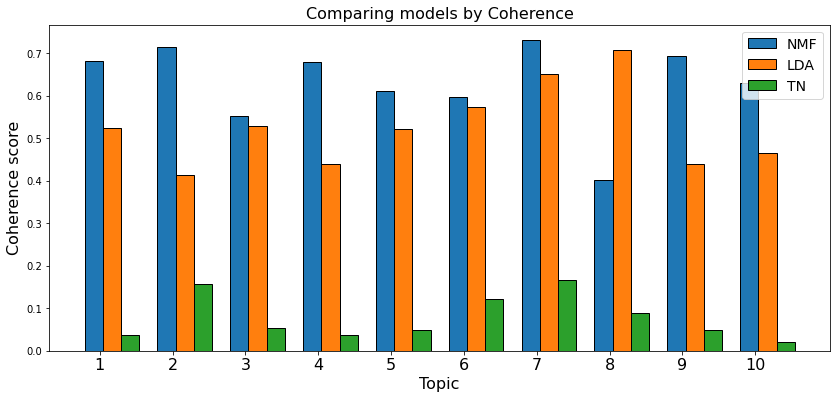

In [ ]:
# comparing coherence of the models

n = 10
r = np.arange(n)
width = 0.25

plt.figure(figsize=(14, 6))

plt.bar(r, coherence_NMF, width = width, edgecolor = 'black', label='NMF')
plt.bar(r + width, coherence_LDA, width = width, edgecolor = 'black', label='LDA')
plt.bar(r + 2*width, coherence_TN, width = width, edgecolor = 'black', label='TN')

plt.title('Comparing models by Coherence', fontsize=16)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Coherence score', fontsize=16)
plt.xticks(r + width/3,['1','2','3','4','5','6','7','8','9','10'], fontsize=16)
plt.legend(fontsize=14)
plt.show()

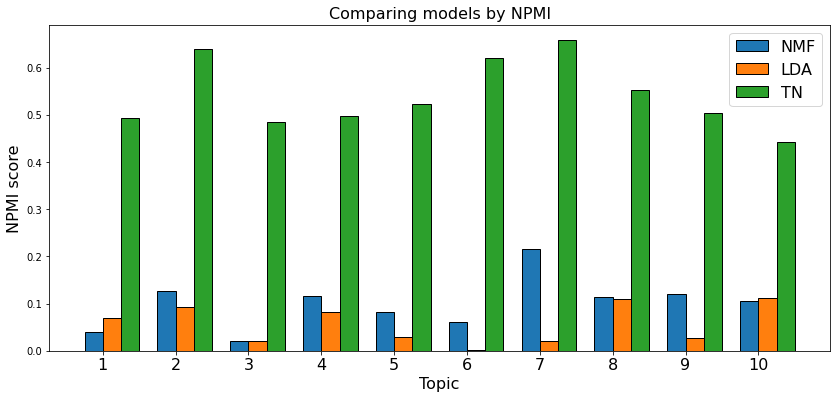

In [ ]:
# comparing NPMI of the models

n = 10
r = np.arange(n)
width = 0.25

plt.figure(figsize=(14, 6))

npmi_NMF = [abs(x) for x in npmi_NMF]
npmi_LDA = [abs(x) for x in npmi_LDA]
npmi_TN = [abs(x) for x in npmi_TN]

plt.bar(r, npmi_NMF, width = width, edgecolor = 'black', label='NMF')
plt.bar(r + width, npmi_LDA, width = width, edgecolor = 'black', label='LDA')
plt.bar(r + 2 * width, npmi_TN, width = width, edgecolor = 'black', label='TN')

plt.title('Comparing models by NPMI', fontsize=16)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('NPMI score', fontsize=16)
plt.xticks(r + width/2,['1','2','3','4','5','6','7','8','9','10'], fontsize=16)
plt.legend(fontsize=16)
plt.show()

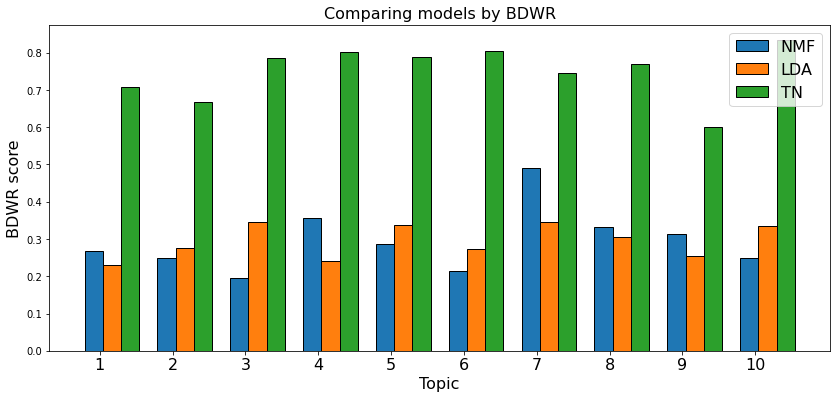

In [ ]:
# comparing BDWR of the models

n = 10
r = np.arange(n)
width = 0.25

plt.figure(figsize=(14, 6))

plt.bar(r, bdwr_NMF, width = width, edgecolor = 'black', label='NMF')
plt.bar(r + width, bdwr_LDA, width = width, edgecolor = 'black', label='LDA')
plt.bar(r + 2*width, bdwr_TN, width = width, edgecolor = 'black', label='TN')

plt.title('Comparing models by BDWR', fontsize=16)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('BDWR score', fontsize=16)
plt.xticks(r + width/3,['1','2','3','4','5','6','7','8','9','10'], fontsize=16)
plt.legend(fontsize=16)
plt.show()